# Downalod Dataset

## Import libraries

In [2]:
import os
import boto3
import logging
import pickle

from pathlib import Path

import matplotlib.pyplot as plt

## Load data

In [3]:
# set up logging
DEBUG_LEVEL = bool(int(os.getenv("DEBUG_LEVEL", 0)))

if DEBUG_LEVEL:
    logging.basicConfig(level=logging.DEBUG)
else:
    logging.basicConfig(level=logging.INFO)

_LOGGER = logging.getLogger(__name__)

IMPORT_DATASET = str(os.environ.get("TUTORIAL_TF_IMPORT_DATASET", "mnist"))

if IMPORT_DATASET == "mnist":
    _LOGGER.info("Selected MNIST Dataset: MNIST handwritten digits dataset.")
    from tensorflow.keras.datasets import mnist as tf_dataset

elif IMPORT_DATASET == "cifar10":
    _LOGGER.info(
        "Selected cifar10 Dataset: CIFAR10 small images classification dataset."
    )
    from tensorflow.keras.datasets import cifar10 as tf_dataset

elif IMPORT_DATASET == "cifar100":
    _LOGGER.info(
        "Selected cifar100 Dataset: CIFAR100 small images classification dataset."
    )
    from tensorflow.keras.datasets import cifar100 as tf_dataset

elif IMPORT_DATASET == "fashion_mnist":
    _LOGGER.info("Selected fashion_mnist Dataset: Fashion-MNIST dataset.")
    from tensorflow.keras.datasets import fashion_mnist as tf_dataset


def _is_file_downloaded(file_downloaded_path: Path) -> bool:
    """Check if file is already downloaded."""
    if os.path.exists(file_downloaded_path):
        _LOGGER.info(
            "{} already exists, skipping ...".format(file_downloaded_path)
        )
        return True

    return False


# Prepare MNIST data.
(x_train, y_train), (x_test, y_test) = tf_dataset.load_data()

INFO:__main__:Selected MNIST Dataset: MNIST handwritten digits dataset.


11493376/11490434 [==============================] - 0s 0us/step


8


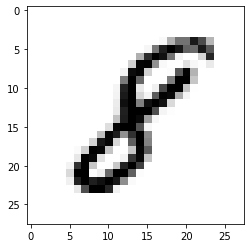

In [4]:
image_index = 7777  # You may select anything up to 60,000
print(y_train[image_index])  # The label is 8
plt.imshow(x_train[image_index], cmap="Greys")

In [5]:
# Set path where to store
directory_path = Path.cwd().parents[0]
destination_path = directory_path.joinpath(
    str(os.environ.get("DESTINATION_DATASET", "data/raw"))
)

project_name = os.environ.get("PROJECT_NAME", "elyra-aidevsecops-tutorial")

if not os.path.exists(destination_path):
    destination_path.mkdir(parents=True, exist_ok=True)

## Store files

In [6]:
use_ceph = bool(int(os.getenv("TUTORIAL_USE_CEPH", 0)))

dataset = {
    "xdata.pkl": x_train,
    "ydata.pkl": y_train,
    "xtestdata.pkl": x_test,
    "ytestdata.pkl": y_test,
}

if use_ceph:
    s3_endpoint_url = os.getenv(
        "ENDPOINT_URL",
        "https://rgw-openshift-storage.apps.cnv.massopen.cloud/",
    )
    s3_access_key = os.environ["AWS_ACCESS_KEY_ID"]
    s3_secret_key = os.environ["AWS_SECRET_ACCESS_KEY"]
    s3_bucket = os.getenv(
        "BUCKET_NAME",
        "test-new-elyra-kfp-79f9251e-19c3-4d80-8b68-969e8495dd34",
    )

    # Create an S3 client
    s3 = boto3.client(
        service_name="s3",
        aws_access_key_id=s3_access_key,
        aws_secret_access_key=s3_secret_key,
        endpoint_url=s3_endpoint_url,
    )

# Store MNIST data for next step.
for data_name, data_file in dataset.items():

    file_downloaded_path = destination_path.joinpath(data_name)

    if not _is_file_downloaded(file_downloaded_path):
        output = open(file_downloaded_path, "wb")
        pickle.dump(data_file, output)
        output.close()
        _LOGGER.info("Stored {}".format(file_downloaded_path))

    if use_ceph:
        key = f"{project_name}/data/raw/{data_name}"
        print(key)
        s3.upload_file(
            Bucket=s3_bucket, Key=key, Filename=str(file_downloaded_path)
        )

INFO:__main__:Stored /home/jovyan/work/elyra-aidevsecops-tutorial/data/raw/xdata.pkl
INFO:__main__:Stored /home/jovyan/work/elyra-aidevsecops-tutorial/data/raw/ydata.pkl
INFO:__main__:Stored /home/jovyan/work/elyra-aidevsecops-tutorial/data/raw/xtestdata.pkl
INFO:__main__:Stored /home/jovyan/work/elyra-aidevsecops-tutorial/data/raw/ytestdata.pkl
